In this file, we aim to reproduce the computations of the paper:
Exponential expressivity in deep neural networks through transient chaos (https://arxiv.org/pdf/1606.05340)


In this paper, we consider the mean field dynamics of random neural networks and how constraints of weight initializations impact their expressivity.
There are many theories which study the expressivity of machine learning. Statistical Learning theory seeks to explain how complex one's model should be in order to approximate a given class of functions
to a given degree of precision (however you want to measure it - l^p, cross entropy, etc...)

(Much of this is copied directly from the paper) As in the paper we consider a deep feedforward NN with D layers of weights $W^1,\ldots, W^D$ and $D+1$  of neural activity vectors $x^0,\ldots x^D$, with $N_l$ neurons in each layer $l$ so that $x^l \in \mathbb{R}^{N_l}$  and $W^l$ is an $N_l\times N_{l-1}$ weight matrix. The feedforward dynamics for input $x^0$ are given by
$$ x^l = \phi(h^l) \qquad h^l = W^lx^{l-1} + b^l \qquad \text{for } l=1,\ldots,D $$

$W^l_{ij}$ are drawn i.i.d. from a mean zero Gaussian with variance $\sigma_w/N_{l-1}$ while the biases are drawn i.i.d from a mean zero Gaussian with variance $\sigma_b^2$. The scaling is to ensure that the neurons at each layer remain $O(1)$ (you may divide by another number to see that everything falls apart, if you like)

We refer the quantity $h^l_i$ as the neural activation of neuron $i$ in layer $l$. We define
$$q^l = \frac{1}{N_l}\sum_{i=1}^{N_l} (h^l_i)^2 $$
as the averaged square activation across layers.

In the limit as the layer width goes to infinity, the average squared activation converges in distribution to a zero mean Gaussian (not sure which version, they don't quote in the paper, but it is certainly a version of the central limit theorem). We call this new gaussian variable $\tilde{q}^l$ and (as in done in the paper) we completely abuse notation and refer to $q^l \equiv E[\tilde{q}^l]$. We have the value of $ E[\tilde{q}^l]$ given by
$$ E[\tilde{q}^l] = \sigma_b^2 +\sigma_w^2 \int \phi (\sqrt{E[\tilde{q}^{l-1}]}z)^2 Dz $$
where $$Dz = \frac{dz}{\sqrt{2\pi}} e^{-x^2/2}.$$


We start our exploration by defining the neural networks we'd like to work with and plotting the empirical distribution of $q^l$.

/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


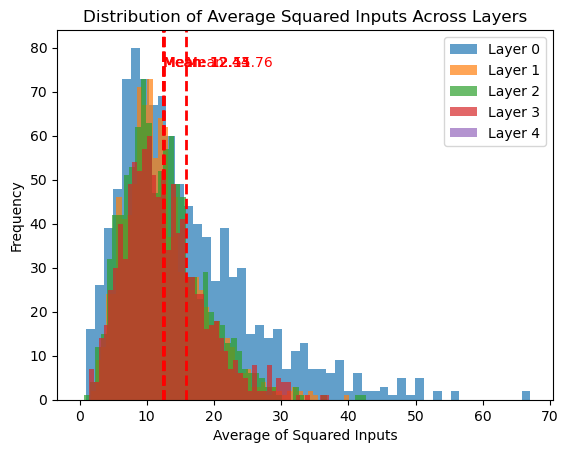

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class DeepFeedforwardNetwork(nn.Module):
    def __init__(self, num_layers, layer_width, sigma_w, sigma_b, activation_function=None):
        """
        Initializes the deep feedforward network.

        :param num_layers: Number of layers in the network (excluding input layer)
        :param layer_width: Number of neurons in each layer
        :param sigma_w: Standard deviation for weight initialization
        :param sigma_b: Standard deviation for bias initialization
        :param activation_function: Nonlinearity function (default is ReLU)
        """
        super(DeepFeedforwardNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_function = activation_function or F.relu

        for _ in range(num_layers):
            layer = nn.Linear(layer_width, layer_width)
            nn.init.normal_(layer.weight, mean=0.0, std=sigma_w / (layer_width)**0.5)
            nn.init.normal_(layer.bias, mean=0.0, std=sigma_b)
            self.layers.append(layer)

    def forward(self, x):
        """
        Performs forward propagation.

        :param x: Input tensor of shape (batch_size, input_size)
        :return: Output tensor after forward propagation
        """
        activations = []
        for layer in self.layers:
            x_linear = layer(x)  # Linear transformation (Wx + b)
            activations.append(x_linear)
            x = self.activation_function(x_linear)
        return x, activations
    
    
def compute_avg_squared_input(num_layers, layer_width, sigma_w, sigma_b, num_networks=1000, num_inputs=1):
    squared_inputs = [[] for _ in range(num_layers + 1)]

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_width, sigma_w, sigma_b, activation_function=torch.tanh)
        inputs = torch.randn(num_inputs, layer_width)  # Standard normal distribution
        _, activations = model(inputs)
        for i, activation in enumerate(activations):
            mean_squared = torch.mean(activation ** 2, dim=0).mean().item()
            squared_inputs[i].append(mean_squared)

    return squared_inputs

# Parameters
num_layers = 4
layer_width = 10
sigma_w = 4
sigma_b = 0.3

# Compute distribution
avg_squared_inputs_distribution = compute_avg_squared_input(num_layers, layer_width, sigma_w, sigma_b)

# Plot the distribution for each layer
for i, data in enumerate(avg_squared_inputs_distribution):
    plt.hist(data, bins=50, alpha=0.7, label=f'Layer {i}')

    # Calculate the mean value of the squared inputs
    mean_value = np.mean(data)
    
    # Plot the mean value as a vertical line
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red')

plt.xlabel('Average of Squared Inputs')
plt.ylabel('Frequency')
plt.title('Distribution of Average Squared Inputs Across Layers')
plt.legend()
plt.show()

One can show fairly easily that 
$$ E[\tilde{q}^l] = \sigma_b^2 +\sigma_w^2 \int \phi (\sqrt{E[\tilde{q}^{l-1}]}z)^2 Dz $$
 should admit a fixed point (it's not too inportant if you aren't aware of the math to do this, you can take this as given) and hence we expect that as $l \to \infty$, $E[\tilde{q}^l] $ will converge. To confirm our prediction, we start by showing the empirical convergence of $$q^l:= \frac{1}{N_l} \sum_{i=1}^{N_l} (h^l_i)^2$$ for a selection of $\sigma_w \in [1.3,2.5,4]$ with $\sigma_b = 0.3$.


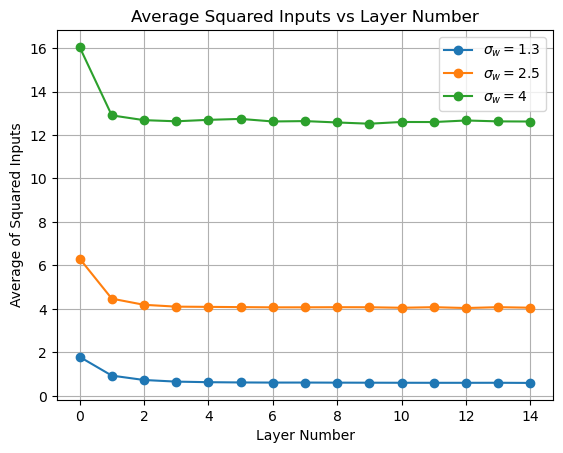

In [38]:
# Parameters
num_layers = 15
layer_width = 80
sigma_b = 0.3


def compute_avg_squared_input(num_layers, layer_width, sigma_w, sigma_b, num_networks=1000, num_inputs=1):
    squared_inputs = [[] for _ in range(num_layers + 1)]

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_width, sigma_w, sigma_b, activation_function=torch.tanh)
        inputs = torch.randn(num_inputs, layer_width)  # Standard normal distribution
        _, activations = model(inputs)
        for i, activation in enumerate(activations):
            mean_squared = torch.mean(activation ** 2, dim=0).mean().item()
            squared_inputs[i].append(mean_squared)

    return [sum(squared_activations)/num_networks for squared_activations in squared_inputs]


for sigma_w in [1.3,2.5,4]:
    # Compute distribution
    avg_squared_inputs_distribution = compute_avg_squared_input(num_layers, layer_width, sigma_w=sigma_w, sigma_b=sigma_b)
    # Plot results
    plt.plot(range(num_layers), avg_squared_inputs_distribution[:-1], marker='o', linestyle='-', label=fr'$\sigma_w = {sigma_w}$')
plt.xlabel('Layer Number')
plt.ylabel('Average of Squared Inputs')
plt.title('Average Squared Inputs vs Layer Number')
plt.legend()
plt.grid(True)
plt.show()


To contrast, we actually compute the mean field convergence of $E[\tilde{q}^l]$.

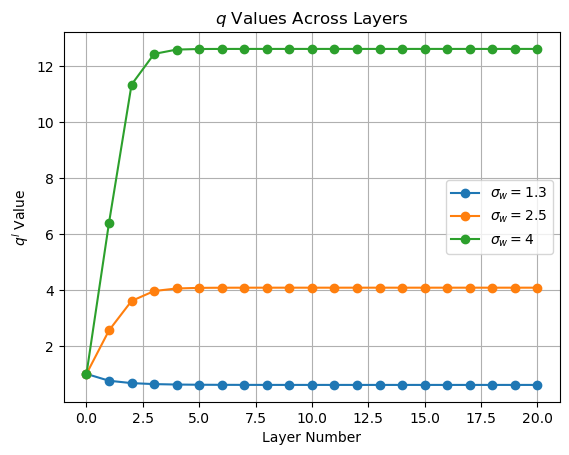

In [37]:
import numpy as np
from scipy.integrate import quad

def gaussian_measure(z):
    """Standard Gaussian measure."""
    return np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)

def compute_q_layers(sigma_w, sigma_b, num_layers, activation_function=None):
    """
    Computes the sequence q^l given by:
    q^l = sigma_b^2 + sigma_w^2 * integral(phi(sqrt(q^{l-1}))^2 Dz)
    
    :param sigma_w: Weight standard deviation (σ_w)
    :param sigma_b: Bias standard deviation (σ_b)
    :param num_layers: Number of layers to compute
    :param activation_function: Activation function (default is ReLU)
    :return: List of q^l values for each layer
    """
    # Default activation function: ReLU
    if activation_function is None:
        activation_function = lambda x: np.maximum(0, x)
    
    def integral_function(q):
        """Function to compute integral of activation squared under Gaussian measure."""
        integrand = lambda z: activation_function(np.sqrt(q) * z)**2 * gaussian_measure(z)
        result, _ = quad(integrand, -np.inf, np.inf)
        return result

    # Initialize q values list
    q_values = [1]  # q^0 = σ_b^2

    for l in range(1, num_layers + 1):
        q_prev = q_values[-1]
        q_new = sigma_b**2 + sigma_w**2 * integral_function(q_prev)
        q_values.append(q_new)

    return q_values

# Example usage
sigma_b = 0.3
num_layers = 20

for sigma_w in [1.3, 2.5, 4]:
    q_values = compute_q_layers(sigma_w, sigma_b, num_layers, activation_function=np.tanh)
    plt.plot(range(num_layers + 1), q_values, marker='o', linestyle='-', label=fr"$\sigma_w = {sigma_w}$")

plt.xlabel(r'Layer Number')
plt.ylabel(r'$q^l$ Value')
plt.title(r'$q$ Values Across Layers')
plt.legend()
plt.grid(True)
plt.show()

Now we turn to computing the covariance matrix between inputs in the propagated layer. As explained in the paper, for 2 input vectors $x^{0,a}$ and $x^{0,b}$, this will be given by:
$$q_{ab}^{l} = \frac{1}{N_l} \sum_{i=1}^{N_l} \mathbf{h}_i^{l} (\mathbf{x}^{0,a}) \mathbf{h}_i^{l} (\mathbf{x}^{0,b}) \quad a, b \in \{1,2\}.$$

This is effectively a $2\times 2$ covariance matrix which describes the dynamics of pairs of neurons as they move through each layer.

There is also an expression for the mean field neuron, however we don't bother with this, since we will see that empirically, the proceeding results agree with the paper. What we really care about is the correlation coefficient, since that will tell us whether or not for a given $\sigma_w$ and $\sigma_b$, the neuron layer is increasing or decreasing the spread of inputs (i.e. allowing for greater expressivity of the network for each layer). It is important to note that the mean field neuron admits two fixed points for the correlation coefficient at $c=0$ and $c=1$. In the next slide, you observe that for different choices of $\sigma_w$ the stability of the fixed points change, cause points to get closer together for small $\sigma_w$ and points to get further apart for larger $\sigma_w$.

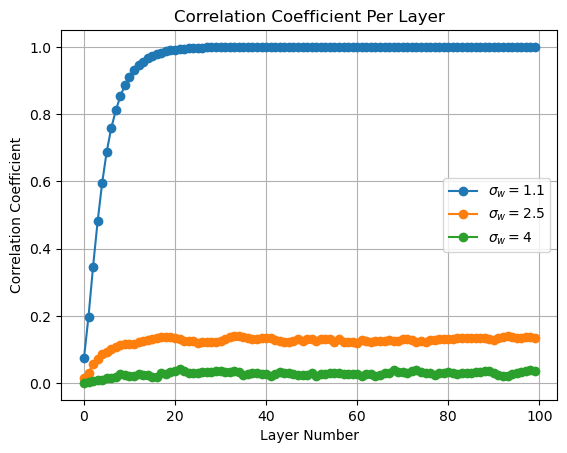

In [46]:
# Function to compute covariance matrix per layer
def compute_covariance_matrices(num_layers, layer_width, sigma_w, sigma_b, num_networks=1000, num_inputs=1):
    covariance_matrices = torch.zeros((num_layers + 1, 2, 2))  # 4x4 matrix for two inputs

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_width, sigma_w, sigma_b,activation_function=torch.tanh)
        inputs_a = torch.randn(num_inputs, layer_width)
        inputs_b = torch.randn(num_inputs, layer_width)

        _, activations_a = model(inputs_a)
        _, activations_b = model(inputs_b)

        for i, (act_a, act_b) in enumerate(zip(activations_a, activations_b)):
            q_aa = torch.mean(act_a * act_a)
            q_bb = torch.mean(act_b * act_b)
            q_ab = torch.mean(act_a * act_b)

            covariance_matrices[i, 0, 0] += q_aa
            covariance_matrices[i, 1, 1] += q_bb
            covariance_matrices[i, 0, 1] += q_ab
            covariance_matrices[i, 1, 0] += q_ab

    avg_covariance_matrices = covariance_matrices / num_networks
    return avg_covariance_matrices

# Function to compute correlation coefficient from covariance matrix
def compute_correlation_coefficient(cov_matrix):
    correlation_coefficients = []
    for i in range(cov_matrix.shape[0]):
        q_aa = cov_matrix[i, 0, 0]
        q_bb = cov_matrix[i, 1, 1]
        q_ab = cov_matrix[i, 0, 1]
        corr = q_ab / (torch.sqrt(q_aa) * torch.sqrt(q_bb))
        correlation_coefficients.append(corr.item())
    return correlation_coefficients

num_layers = 100  # Number of layers
layer_width = 100  # Same width for all layers
sigma_b = 0.3  # Standard deviation for biases

# Compute covariance matrices and correlation coefficients
avg_covariance_matrices = compute_covariance_matrices(num_layers, layer_width, sigma_w, sigma_b)
correlation_coefficients = compute_correlation_coefficient(avg_covariance_matrices)

for sigma_w in [1.1,2.5,4]: 
    # Compute covariance matrices and correlation coefficients
    avg_covariance_matrices = compute_covariance_matrices(num_layers, layer_width, sigma_w, sigma_b)
    correlation_coefficients = compute_correlation_coefficient(avg_covariance_matrices)
    # Plot the correlation coefficients per layer
    plt.plot(range(num_layers + 1), correlation_coefficients, marker='o', linestyle='-', label= fr"$\sigma_w = {sigma_w}$")
plt.xlabel('Layer Number')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient Per Layer')
plt.legend()
plt.grid(True)
plt.show()

We demonstrate the significance of the stability of the correlation coefficient fixed points by showing how this causes inputs that start close to each other to either spread out of get closer. To do this, we first write code which will embed a 100 point mesh of $[1,1]^2 \in \mathbb{R}^2$ into $\mathbb{R}^{40}$ where 40 refers to the layer_width parameter that we have chosen arbitrarily to use. We then also write code which projects a vector in $\mathbb{R}^40$ to the the subspace which the embedded $[1,1]^2 \in \mathbb{R}^2$ spans.

Projected 2D shape: torch.Size([100, 2])
Sample projected points:
 tensor([[-1.0000, -1.0000],
        [-1.0000, -0.7778],
        [-1.0000, -0.5556],
        [-1.0000, -0.3333],
        [-1.0000, -0.1111]])


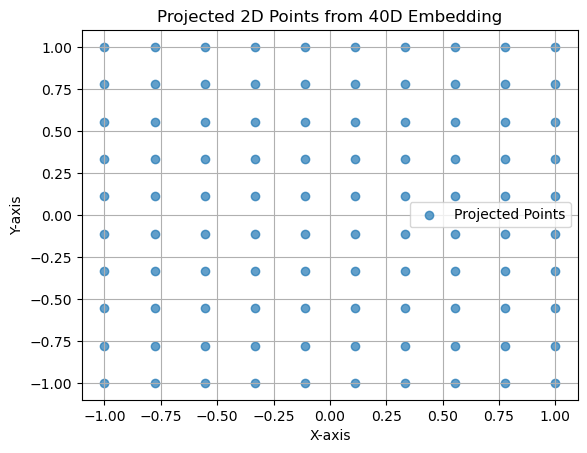

In [50]:
import torch
import numpy as np
import itertools

# Function to embed 2D space into 40D
def embed_2d_to_40d(grid_size=10):
    x_vals = np.linspace(-1, 1, grid_size)
    y_vals = np.linspace(-1, 1, grid_size)
    grid_2d = np.array(list(itertools.product(x_vals, y_vals)))

    num_2d_points = grid_2d.shape[0]
    num_40d_dims = 40

    embedded_points = np.zeros((num_2d_points, num_40d_dims))
    for i in range(num_40d_dims):
        embedded_points[:, i] = grid_2d[:, i % 2]  # Alternate x and y values

    return torch.tensor(embedded_points, dtype=torch.float32), grid_2d

# Function to project 40D points back to 2D
def project_40d_to_2d(embedded_points):
    """
    Projects 40D points back to the original 2D subspace.
    The projection extracts the alternating x and y components.

    :param embedded_points: Tensor of shape (N, 40), where N is the number of points
    :return: Tensor of shape (N, 2) with projected 2D points
    """
    projected_2d = torch.zeros((embedded_points.shape[0], 2), dtype=torch.float32)
    projected_2d[:, 0] = embedded_points[:, 0::2].mean(dim=1)
    projected_2d[:, 1] = embedded_points[:, 1::2].mean(dim=1)
    return projected_2d


# Example usage
embedded_data, mesh_data = embed_2d_to_40d()
projected_data = project_40d_to_2d(embedded_data)

print("Projected 2D shape:", projected_data.shape)
print("Sample projected points:\n", projected_data[:5])

# Visualize the projected points
import matplotlib.pyplot as plt

plt.scatter(projected_data[:, 0].numpy(), projected_data[:, 1].numpy(), alpha=0.7, label="Projected Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Projected 2D Points from 40D Embedding")
plt.legend()
plt.grid(True)
plt.show()

For the 3 different choices of $\sigma_w$ we have been studying, we plot the effect of running 2D mesh through each layer. notice for small $\sigma_w$ the grid points get closer with each layer and for larger $\sigma_w$ the grid points spread out with each layer.

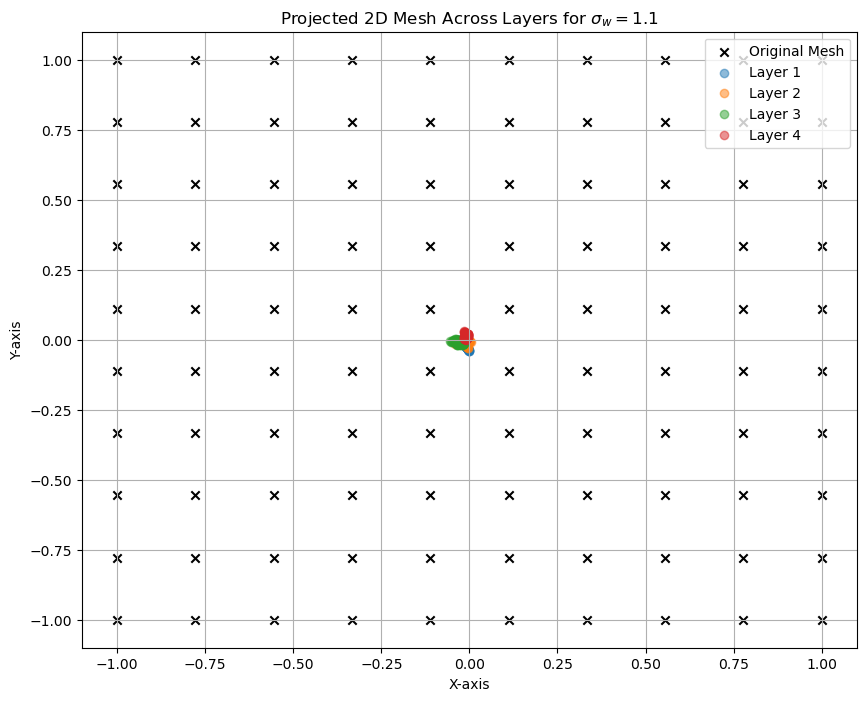

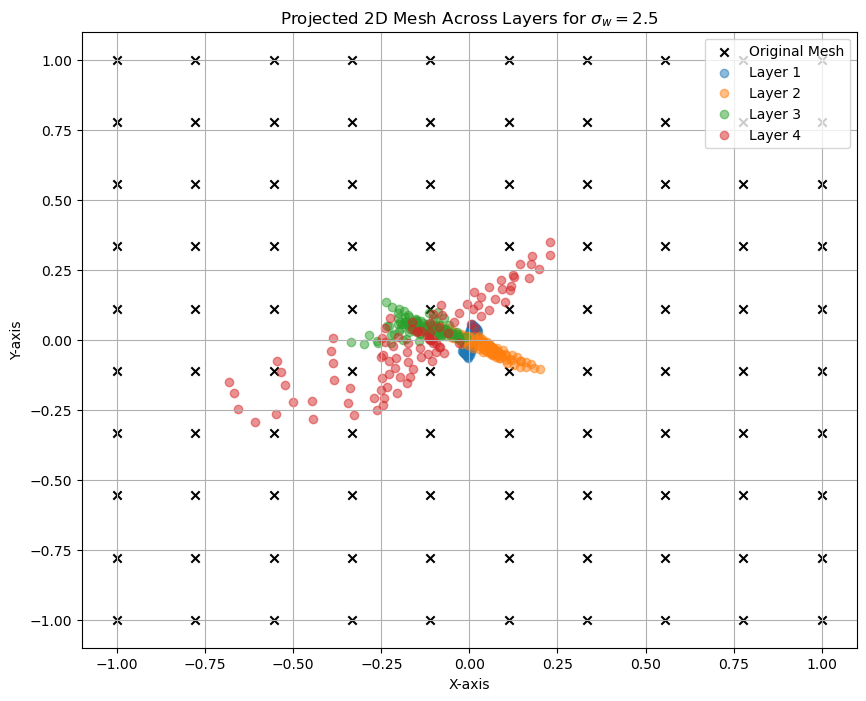

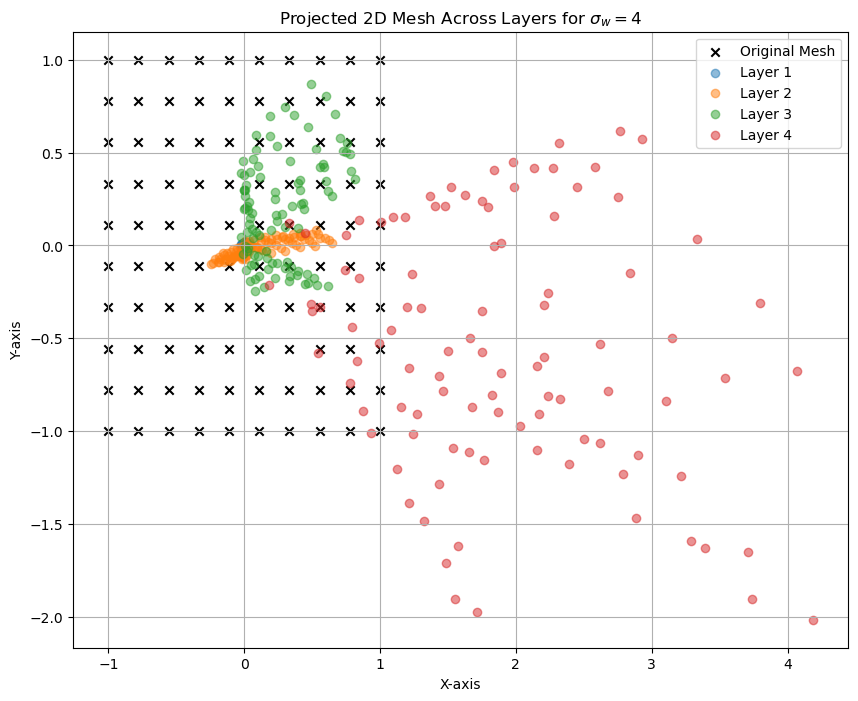

In [56]:
# Parameters
num_layers = 4
layer_width = 40
sigma_b = 0.3
num_networks = 100


for sigma_w in [1.1,2.5,4]:
    # Generate the 2D mesh and embed into 40D
    embedded_data, original_2d_mesh = embed_2d_to_40d()

    # Accumulate activations across multiple networks
    layerwise_activations = torch.zeros((num_layers, embedded_data.shape[0], layer_width))

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_width, sigma_w, sigma_b)
        _, activations = model(embedded_data)
        for i in range(num_layers):
            layerwise_activations[i] += activations[i]

    # Take the average over all networks
    avg_activations = layerwise_activations / num_networks

    # Project each layer's activations back to 2D and visualize
    plt.figure(figsize=(10, 8))

    # Plot original mesh for reference
    plt.scatter(original_2d_mesh[:, 0], original_2d_mesh[:, 1], color='black', marker='x', label='Original Mesh')
    for i in range(num_layers):
        projected_mesh = project_40d_to_2d(avg_activations[i])
        plt.scatter(projected_mesh[:, 0].detach().numpy(), projected_mesh[:, 1].detach().numpy(), alpha=0.5, label=f'Layer {i + 1}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(fr'Projected 2D Mesh Across Layers for $\sigma_w = {sigma_w}$')
    plt.legend()
    plt.grid(True)
    plt.show()

There are some other interesting things going on this paper regarding the Riemannian curvature of embedded spaces per layer. This result is used to demonstrate the exponential expressivity of Neural networks as the depth increases. I would recommend that you check out this paper for more details!